In [239]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib
import seaborn as sns
from matplotlib import pylab as plt
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['agg.path.chunksize'] = 10000

pd.set_option('display.max_columns', None)

In [490]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [241]:
df = pd.read_csv('data/weather_madrid_LEMD_1997_2015.csv')

# Exploration

In [242]:
rename_dict =  {'CET'                           :'date',
                'Max TemperatureC'              :'temperature_max',
                'Mean TemperatureC'             :'temperature',
                'Min TemperatureC'              :'temperature_min',
                'Dew PointC'                    :'dewpoint_max',
                'MeanDew PointC'                :'dewpoint',
                'Min DewpointC'                 :'dewpoint_min',
                'Max Humidity'                  :'humidity_max',
                ' Mean Humidity'                :'humidity',
                ' Min Humidity'                 :'humidity_min',
                ' Max Sea Level PressurehPa'    :'pressure_max',
                ' Mean Sea Level PressurehPa'   :'pressure',
                ' Min Sea Level PressurehPa'    :'pressure_min',
                ' Max VisibilityKm'             :'visibility_max',
                ' Mean VisibilityKm'            :'visibility',
                ' Min VisibilitykM'             :'visibility_min',
                ' Max Wind SpeedKm/h'           :'windspeed_max',
                ' Mean Wind SpeedKm/h'          :'windspeed',
                ' Max Gust SpeedKm/h'           :'gustspeed',      
                'Precipitationmm'               :'precipitation',
                ' CloudCover'                   :'cloudcover',
                ' Events'                       :'events',
                'WindDirDegrees'                :'winddirection',
                }
df.rename(columns=rename_dict, inplace=True)

In [243]:
# Dates are strings:
df.date[0]

'1997-1-1'

In [244]:
# Date conversions:
df.date = pd.to_datetime(df.date)
df['DOY'] = (df.date.dt.dayofyear / (365+df.date.dt.is_leap_year)) # as decimal in (0,1]
df['Year_f'] = df.date.dt.year + df.DOY

In [245]:
len(df)

6812

In [246]:
[test_df,df] = [df.loc[df.date.dt.year>=2013],df.loc[df.date.dt.year<2013]]




In [247]:
print(len(df),len(test_df))

5717 1095


In [267]:
dfD = df.set_index('date',drop=False)
dfFull = pd.DataFrame(index=pd.date_range(start=df.date.min(),end=df.date.max()),columns=df.columns)
dfFull.update(dfD)
dfFull.date = pd.date_range(start=df.date.min(),end=df.date.max())   # not sure why this one doesn't update like the others

In [275]:
dfFull.iloc[1143:1152]

,date,temperature_max,temperature,temperature_min,dewpoint_max,dewpoint,dewpoint_min,humidity_max,humidity,humidity_min,pressure_max,pressure,pressure_min,visibility_max,visibility,visibility_min,windspeed_max,windspeed,gustspeed,precipitation,cloudcover,events,winddirection,DOY,Year_f
2000-02-18,2000-02-18,18,10,2,6,4,0,87,71,42,1028,1026,1024,NaN,NaN,NaN,10,3,NaN,0,NaN,NaN,18,0.13388,2000.13
2000-02-19,2000-02-19,20,10,1,5,2,-1,87,66,32,1025,1024,1021,NaN,NaN,NaN,19,3,NaN,0,NaN,NaN,33,0.136612,2000.14
2000-02-20,2000-02-20,18,9,1,5,2,-1,87,65,32,1025,1023,1021,NaN,NaN,NaN,8,3,NaN,0,NaN,NaN,328,0.139344,2000.14
2000-02-21,2000-02-21,17,8,0,5,1,-2,93,66,36,1026,1024,1023,NaN,NaN,NaN,11,5,NaN,0,NaN,NaN,334,0.142077,2000.14
2000-02-22,2000-02-22,16,8,1,4,2,-1,87,69,36,1024,1023,1022,10,9,9,6,3,NaN,0,6,NaN,359,0.144809,2000.14
2000-02-23,2000-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-24,2000-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-25,2000-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-26,2000-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [278]:
nullCells = dfFull.isnull()

In [290]:
print(sum(nullCells.temperature))
print(sum(nullCells.temperature[:pd.Timestamp('2000-02-22')]))
print(sum(nullCells.temperature[:pd.Timestamp('2004-02-01')]))

130
0
130


In [201]:
df.head()

,date,temperature_max,temperature,temperature_min,dewpoint_max,dewpoint,dewpoint_min,humidity_max,humidity,humidity_min,pressure_max,pressure,pressure_min,visibility_max,visibility,visibility_min,windspeed_max,windspeed,gustspeed,precipitation,cloudcover,events,winddirection,DOY,Year_f
0,1997-01-01,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,1008,1004,10.0,9.0,4.0,13,6,NaN,0.0,6.0,NaN,229,0.002740,1997.002740
1,1997-01-02,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007,1003,997,10.0,9.0,4.0,26,8,47.0,0.0,5.0,Rain,143,0.005479,1997.005479
2,1997-01-03,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005,999,996,10.0,10.0,7.0,27,19,NaN,0.0,6.0,Rain-Snow,256,0.008219,1997.008219
3,1997-01-04,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012,1010,1005,10.0,10.0,10.0,27,19,40.0,0.0,2.0,NaN,284,0.010959,1997.010959
4,1997-01-05,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012,1008,1005,10.0,5.0,1.0,14,6,NaN,0.0,7.0,Snow,2,0.013699,1997.013699


In [206]:
df.describe()

,temperature_max,temperature,temperature_min,dewpoint_max,dewpoint,dewpoint_min,humidity_max,humidity,humidity_min,pressure_max,pressure,pressure_min,visibility_max,visibility,visibility_min,windspeed_max,windspeed,gustspeed,precipitation,cloudcover,winddirection,DOY,Year_f
count,5715.000000,5714.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,5715.000000,5717.000000,5717.000000,5717.000000,4777.000000,4777.000000,4777.000000,5717.000000,5717.000000,2682.000000,5717.000000,4630.000000,5717.000000,5717.000000,5717.000000
mean,20.875941,14.519776,8.587402,8.030796,4.902012,1.415923,81.137533,58.456868,36.221347,1020.398461,1018.003848,1015.529823,11.010467,9.919824,8.504919,21.658037,9.006297,43.663311,0.020388,3.239525,195.519853,0.506633,2005.086658
std,8.841317,7.565159,6.832758,4.783309,4.694278,4.958462,17.396003,19.629104,19.221618,6.068196,6.394319,6.801470,4.675784,3.066143,3.895358,9.784401,5.081384,12.337341,0.507565,1.792508,120.985340,0.288340,4.629175
min,0.000000,-3.000000,-10.000000,-12.000000,-15.000000,-22.000000,16.000000,15.000000,4.000000,996.000000,990.000000,965.000000,1.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,-1.000000,0.002732,1997.002740
25%,13.000000,8.000000,3.000000,5.000000,2.000000,-2.000000,68.000000,42.000000,20.000000,1017.000000,1014.000000,1012.000000,10.000000,10.000000,7.000000,13.000000,5.000000,35.000000,0.000000,2.000000,60.000000,0.257534,2001.180822
50%,20.000000,14.000000,9.000000,8.000000,5.000000,2.000000,87.000000,59.000000,33.000000,1020.000000,1018.000000,1016.000000,10.000000,10.000000,10.000000,21.000000,8.000000,42.000000,0.000000,3.000000,223.000000,0.509589,2005.175342
75%,29.000000,21.000000,14.000000,12.000000,8.000000,5.000000,94.000000,75.000000,49.000000,1024.000000,1022.000000,1020.000000,10.000000,10.000000,10.000000,27.000000,11.000000,52.000000,0.000000,5.000000,299.000000,0.756164,2009.087671
max,41.000000,32.000000,28.000000,20.000000,16.000000,14.000000,100.000000,100.000000,100.000000,1041.000000,1040.000000,1038.000000,31.000000,31.000000,31.000000,182.000000,39.000000,103.000000,32.000000,8.000000,360.000000,1.000000,2013.000000


Plot Mean Temperature Data, showing Missing Dates:

In [396]:
# helper plot function
def plot_series(dfs, cols, *args, **kwargs):
    if not(isinstance(dfs,list)):
        plot_series([dfs],cols,*args,**kwargs)
    elif not(isinstance(cols,list)):
        plot_series(dfs,[cols],*args, **kwargs)
    else:
        plt.figure(figsize=(16,6))
        if ('xlabel' in kwargs):
            plt.xlabel(kwargs.pop('xlabel'))
        if ('ylabel' in kwargs):
            plt.ylabel(kwargs.pop('ylabel'))
        elif (len(cols)==1):
            plt.ylabel(cols[0])
        if (len(dfs)<len(cols)):
            assert (len(dfs)==1)
            dfs = dfs*len(cols)
        elif (len(dfs)>len(cols)):
            assert (len(cols)==1)
            cols = cols*len(dfs)
        for j in range(len(dfs)):
            try:
                t=dfs[j].date
                plt.xlabel('date')
            except:
                t=dfs[j].index
            if (isinstance(dfs[j],pd.DataFrame)):
                series = dfs[j][cols[j]]
            else:
                series = pd.Series(dfs[j])
                cols[j] = (cols[j] if (cols[j]) else series.name)
            plt.plot(t,series,label=cols[j],*args,**kwargs)
        plt.legend()
        plt.show()

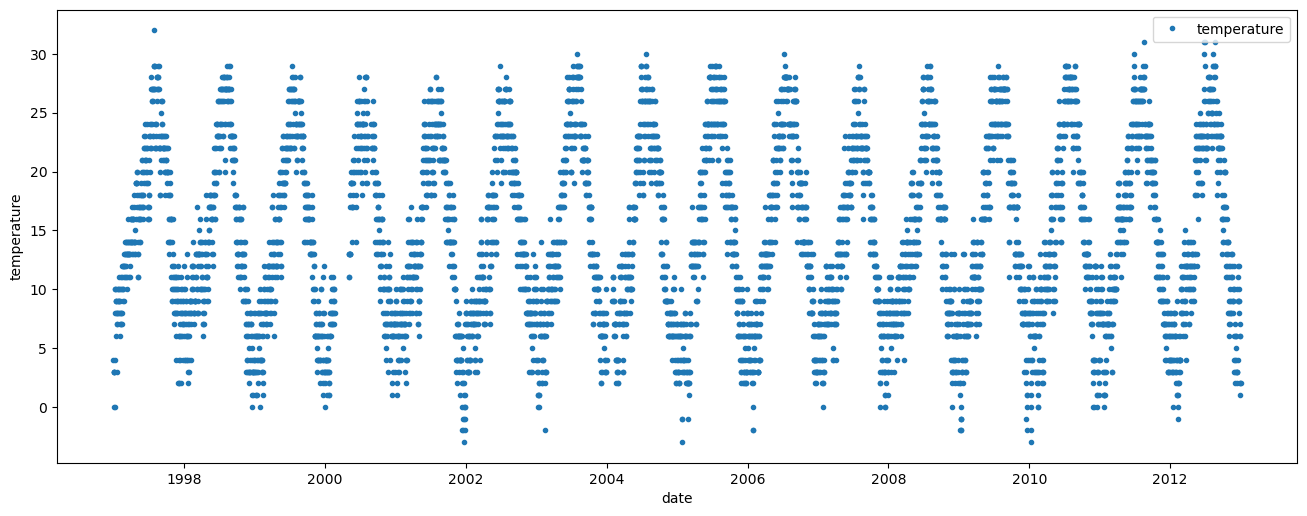

In [397]:
plot_series(df,'temperature','.')

Observations:
    
1) Seasonality! (of course)

2) No obvious trend, but we'll look

3) Missing Data

4) Measurements are integers, but the frequency distribution is unnatural. Unexpectedly few data points have values at odd integer multiples of 5... why?


Discretization of Values:

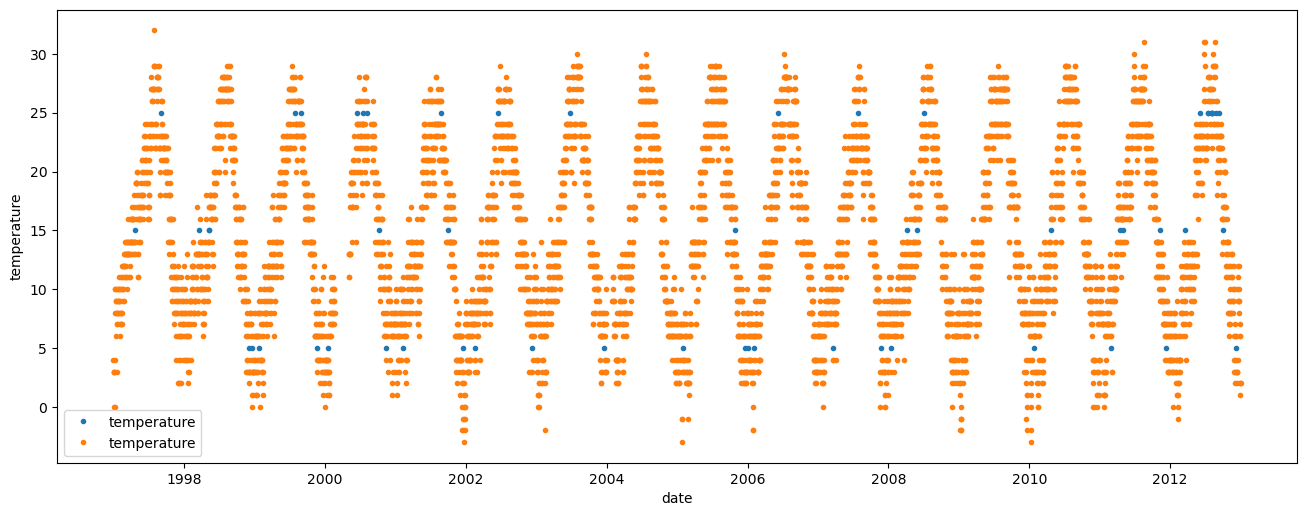

In [398]:
odd5 = ((~(df.temperature%5).astype(bool)) & ((df.temperature%2).astype(bool)))
plot_series([df.loc[odd5],df.loc[~odd5]],'temperature','.')

Text(0, 0.5, 'Value Count')

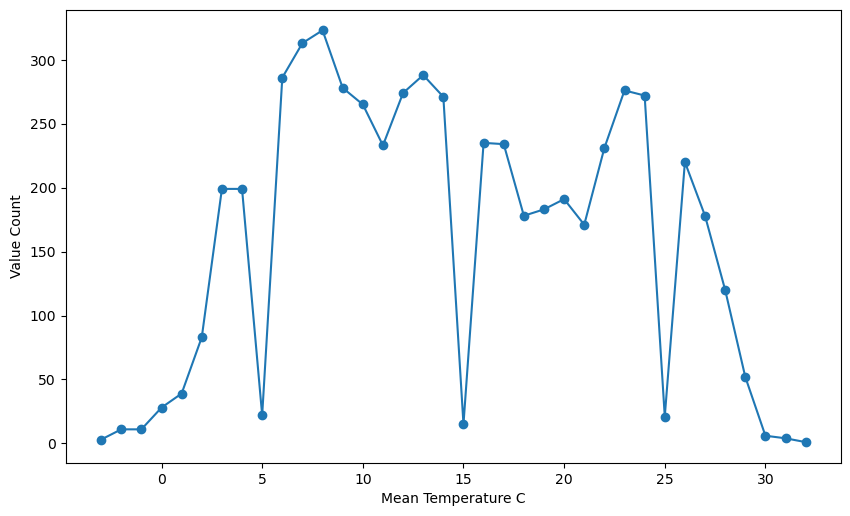

In [399]:
VC = df.temperature.value_counts().sort_index()
plt.plot(VC.index,VC,'-o')
plt.xlabel('Mean Temperature C')
plt.ylabel('Value Count')

Temperatures ending in '5' are suppressed by ~ 10x

Probably not due to binning

Also, there exists no similar structure within temperature_max or temperature_min:

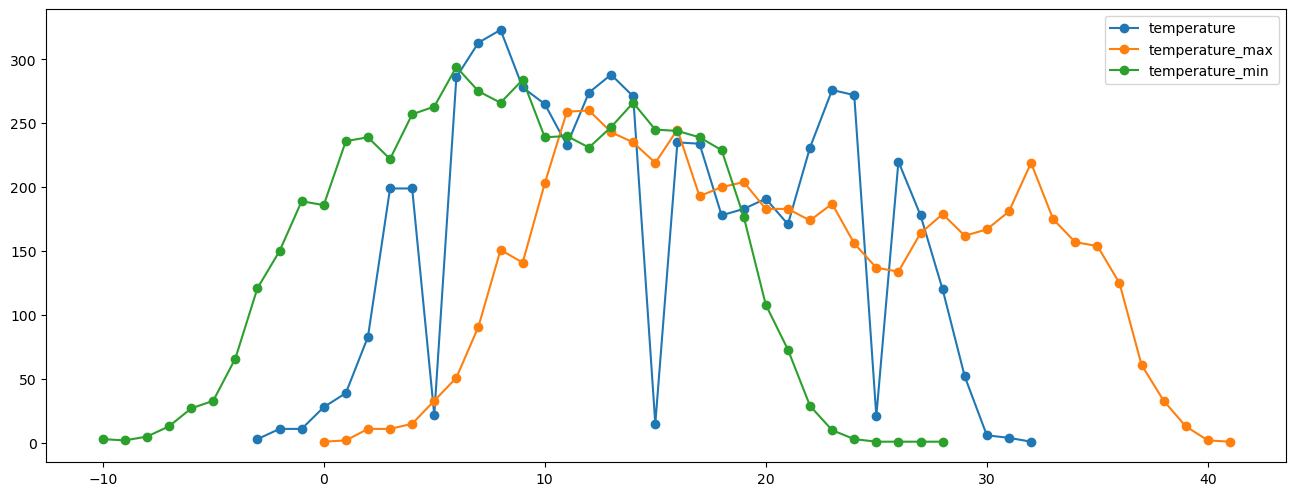

In [400]:
VC = df.temperature.value_counts().sort_index()
cols4plot = ['temperature','temperature_max','temperature_min']
plot_series([df[col].value_counts().sort_index() for col in cols4plot],None,'-o')

Text(0, 0.5, 'MeanTemperature')

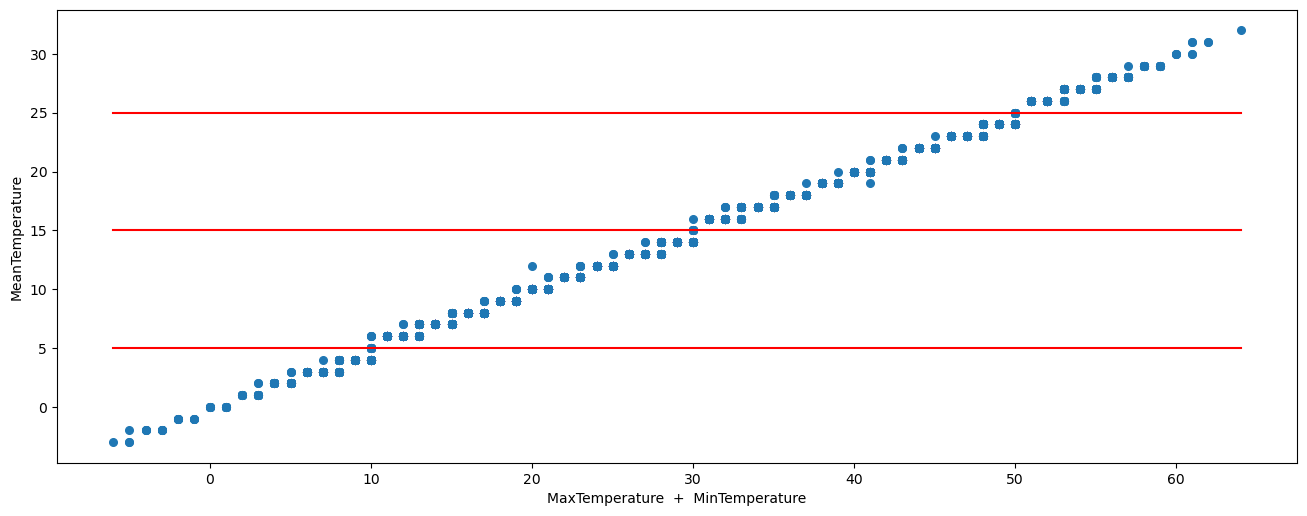

In [401]:
plt.figure(figsize=(16,6))
plt.plot((1.0*(df.temperature_max+df.temperature_min)),df.temperature,'.',markersize=11)
plt.plot([2*df.temperature.min(),2*df.temperature.max()],[5,5],'r')
plt.plot([2*df.temperature.min(),2*df.temperature.max()],[15,15],'r')
plt.plot([2*df.temperature.min(),2*df.temperature.max()],[25,25],'r')
plt.xlabel('MaxTemperature  +  MinTemperature')
plt.ylabel('MeanTemperature')

## Missing Data

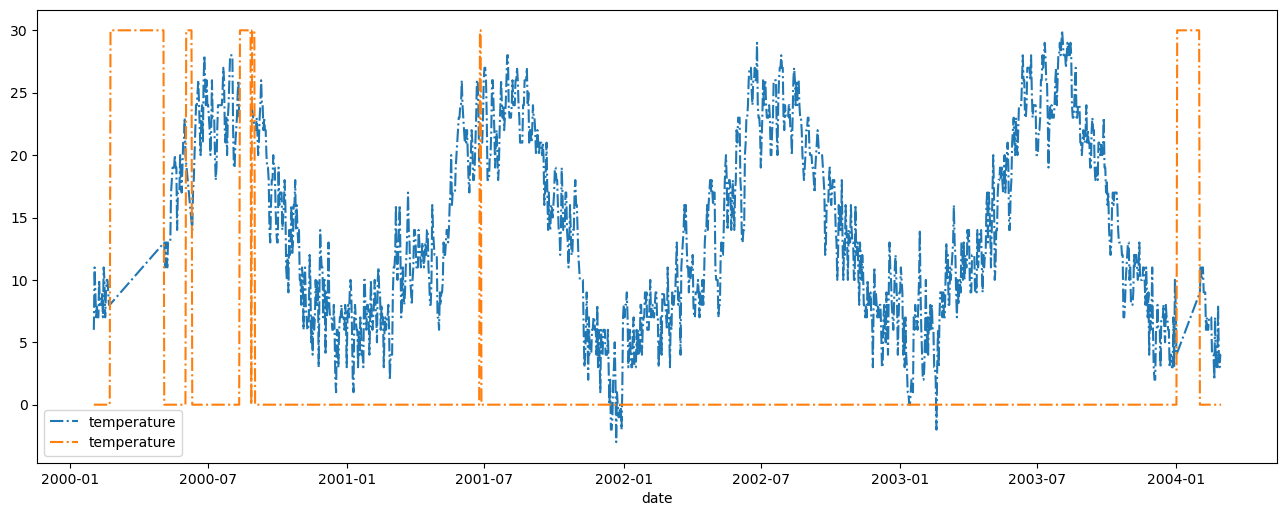

In [402]:
timeBounds = [pd.Timestamp('2000-02-01'),pd.Timestamp('2004-03-01')]
roughPatch_full = (dfFull.date >= timeBounds[0]) & (dfFull.date < timeBounds[1])
roughPatch_orig = (df.date >= timeBounds[0]) & (df.date < timeBounds[1])
plot_series([df[roughPatch_orig],dfFull[roughPatch_full].temperature.isnull()*30],['temperature',None],'-.')

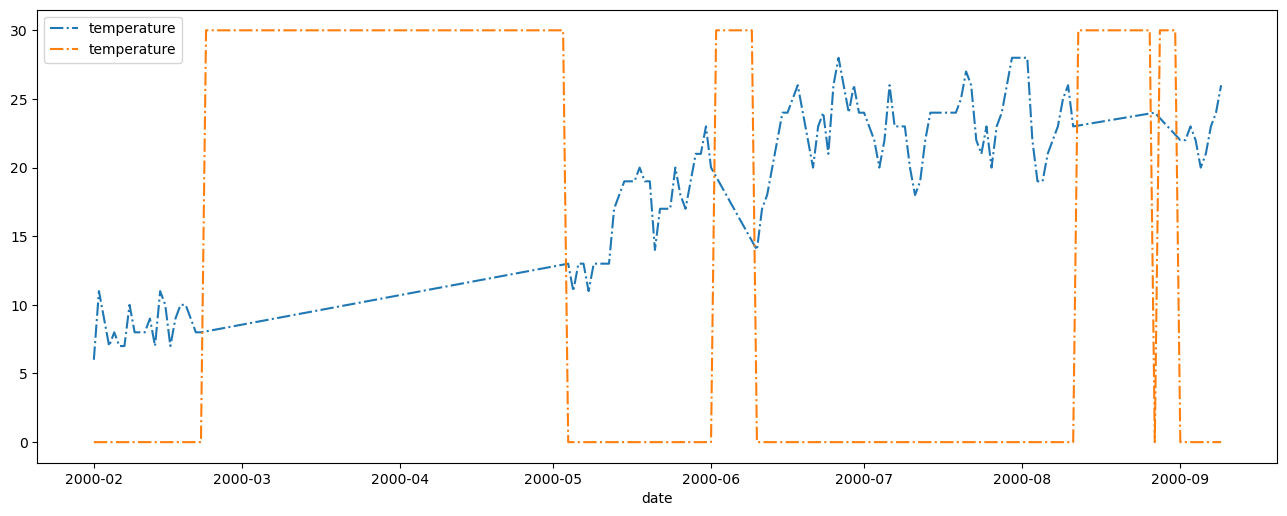

In [403]:
timeBounds = [pd.Timestamp('2000-02-01'),pd.Timestamp('2000-09-10')]
calendarSelection_full = (dfFull.date >= timeBounds[0]) & (dfFull.date < timeBounds[1])
calendarSelection_orig = (df.date >= timeBounds[0]) & (df.date < timeBounds[1])
plot_series([df[calendarSelection_orig&(~df.temperature.isnull())],dfFull[calendarSelection_full].temperature.isnull()*30],
                 ['temperature',None],'-.')

What to do about the missing data?

Some options:
    
One option: Select only the data starting at 2004 Feb 01. This is a substantial contiguous block to work with. With this choice, we are hypothesizing that weather patterns won't vary so much across years that our earliest data would become necessary to improve model generalization.

It's interesting to investigate this however. Can we do better by including the earliest data? And if so, how should we include that early data?

In [ ]:
We would like to study whether we lose any predictive power from 

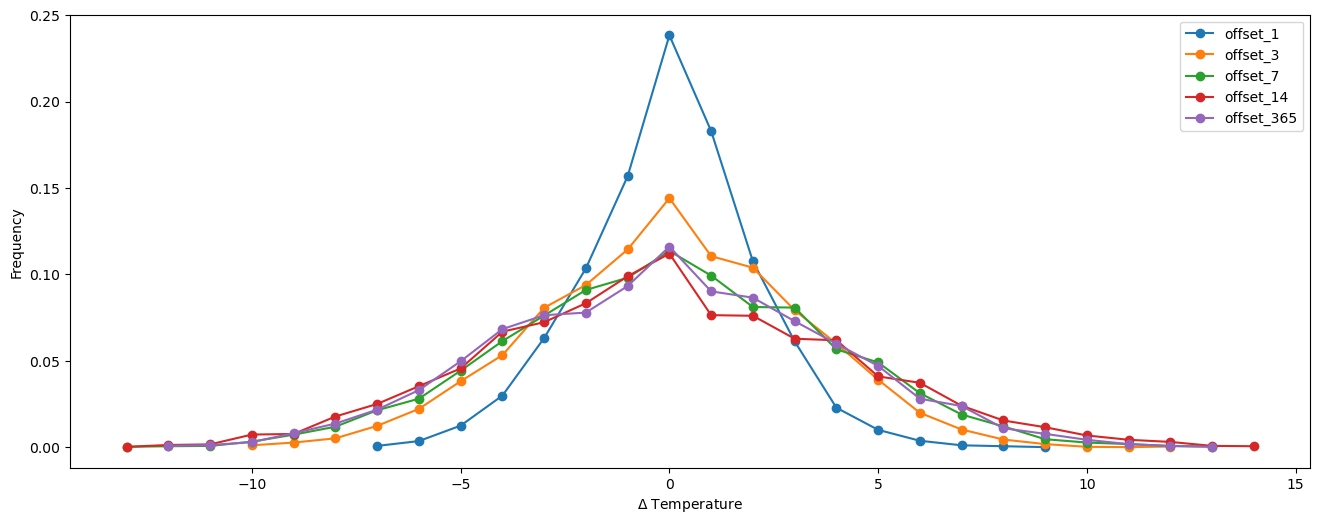

In [434]:
offsets = [1,3,7,14,365]
diff_ps = [dfFull.temperature.diff(oo).rename('offset_%d'%oo) for oo in offsets]
valueCount_ps = [dfFull.temperature.diff(oo).value_counts() for oo in offsets]
diffsHistograms_List = [vcps.sort_index()/vcps.sum() for vcps in valueCount_ps]
names = ['offset_%d'%oo for oo in offsets]
plot_series(diffsHistograms_List,names,'-o',xlabel='$\Delta$ Temperature',ylabel='Frequency')

In [435]:
for j in range(len(offsets)):
    print((offsets[j],diff_ps[j].std()))

(1, 2.0385777901759914)
(3, 3.1810732646393585)
(7, 3.811157343275272)
(14, 4.267388359138501)
(365, 3.93290372039285)


No handles with labels found to put in legend.


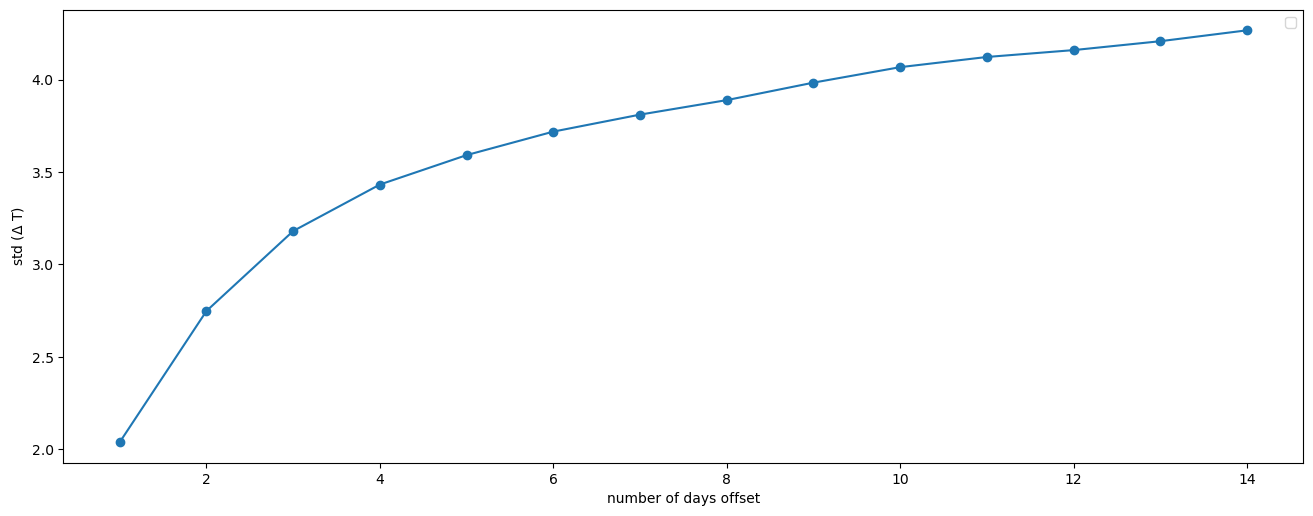

In [444]:
std_list = [dfFull.temperature.diff(oo).std() for oo in range(1,15)]
plot_series(pd.Series(std_list,index=list(range(1,15))),None,
                 '-o',xlabel='number of days offset',ylabel='std ($\Delta$ T)')

In [445]:
for j in range(len(offsets)):
    print((offsets[j],diff_ps[j].abs().mean()))

(1, 1.5284738041002277)
(3, 2.500877808988764)
(7, 3.020257178087018)
(14, 3.3666784702549575)
(365, 3.1281854761448553)


No handles with labels found to put in legend.


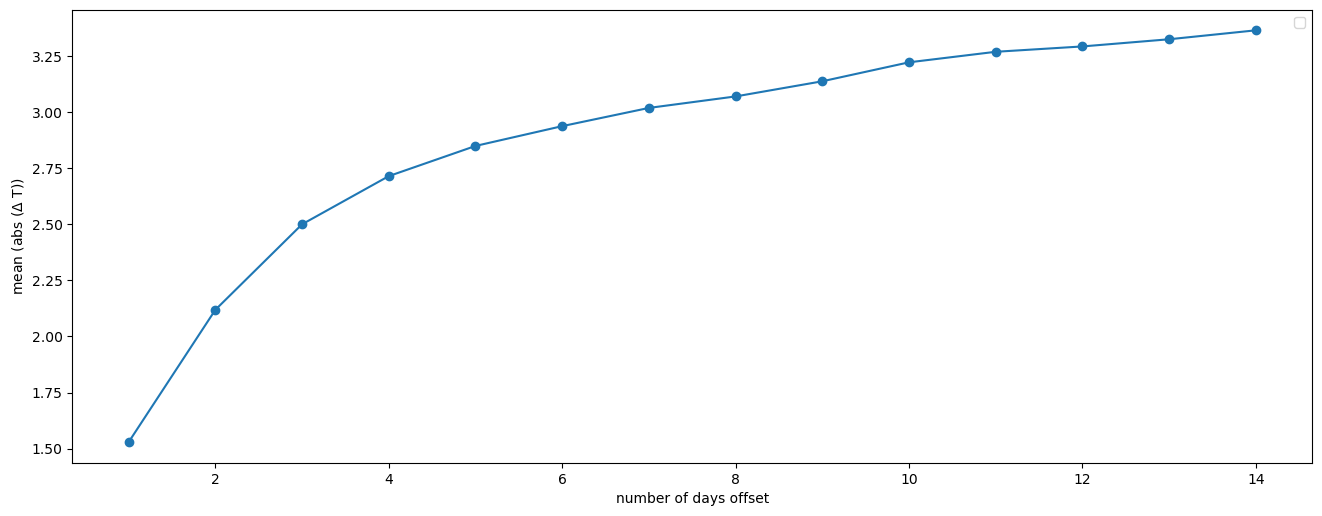

In [443]:
std_list = [dfFull.temperature.diff(oo).abs().mean() for oo in range(1,15)]
plot_series(pd.Series(std_list,index=list(range(1,15))),None,
                 '-o',xlabel='number of days offset',ylabel='mean (abs ($\Delta$ T))')

In [441]:
dfFull.temperature.diff(1).abs().mean()

1.5284738041002277

## Investigate Trend

Is there a trend in this data?

In [474]:
completeYears = ~dfFull.temperature.isnull().groupby(dfFull.date.dt.year).any()
yearlyMeanTemperature = (dfFull.groupby(dfFull.date.dt.year)['temperature'].sum()/ \
        dfFull.groupby(dfFull.date.dt.year)['temperature'].count()).loc[completeYears]


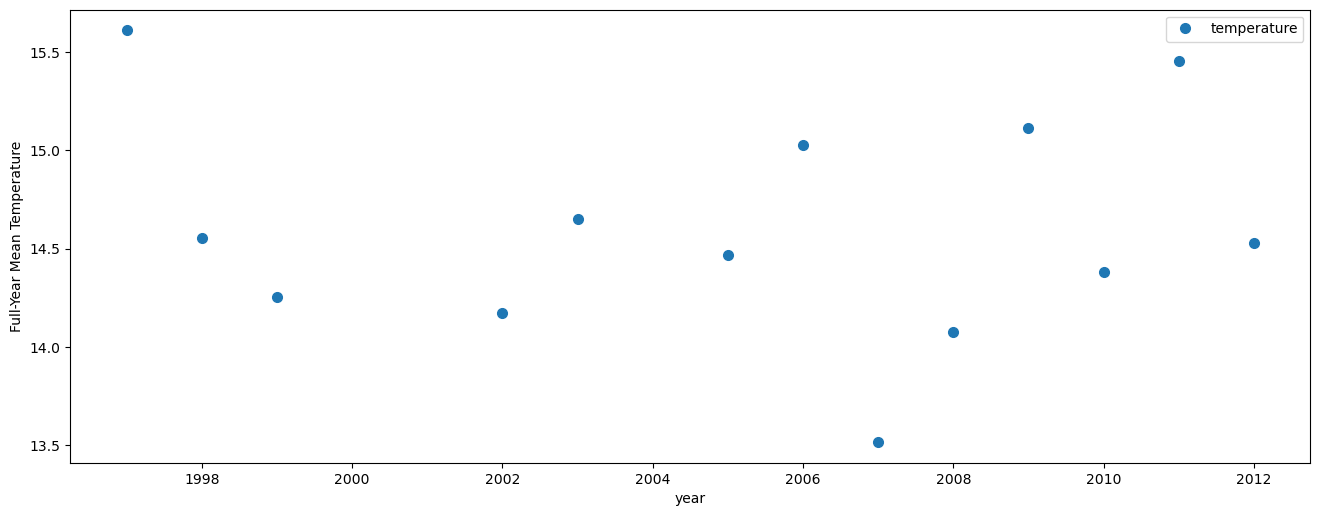

In [481]:
plot_series(yearlyMeanTemperature,None,'.',markersize=14,xlabel='year',ylabel='Full-Year Mean Temperature')

In [ ]:
# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html

In [512]:
sm_trendModel_validFullYears = OLS(yearlyMeanTemperature,sm.add_constant(yearlyMeanTemperature.index),missing='drop')
results = sm_trendModel_validFullYears.fit()
print(results.params)
print()
print(results.tvalues)
print()
print(results.t_test([0,1]))
print()
#print(results.HC0_se)

const    29.512935
x1       -0.007437
dtype: float64

const    0.422889
x1      -0.213686
dtype: float64

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0074      0.035     -0.214      0.835      -0.084       0.069



In [ ]:
# Repeat trend-line regression in sklearn:

In [533]:
(X,y) = (yearlyMeanTemperature.index.to_numpy().reshape(-1, 1)-1997,yearlyMeanTemperature)
sk_trendModel_validFullYears = LinearRegression().fit(X,y)

In [534]:
print(sk_trendModel_validFullYears.score(X, y))
print((sk_trendModel_validFullYears.coef_,sk_trendModel_validFullYears.intercept_))

0.0041339076038137135
(array([-0.00743726]), 14.660726345029062)


We'll model with zero trend.

# Seasonality

We know the underlying period is exactly one year.

Can we fit our observations with a single sin/cos (no harmonics)?

In [539]:
maxFreq=10
for freq in range(1,1+maxFreq):
    dfD['sin_%02d'%freq] = np.sin(2*np.pi*dfD.DOY*freq)
    dfD['cos_%02d'%freq] = np.cos(2*np.pi*dfD.DOY*freq)

In [540]:
dfD.head()

,date,temperature_max,temperature,temperature_min,dewpoint_max,dewpoint,dewpoint_min,humidity_max,humidity,humidity_min,pressure_max,pressure,pressure_min,visibility_max,visibility,visibility_min,windspeed_max,windspeed,gustspeed,precipitation,cloudcover,events,winddirection,DOY,Year_f,sin_01,cos_01,sin_02,cos_02,sin_03,cos_03,sin_04,cos_04,sin_05,cos_05,sin_06,cos_06,sin_07,cos_07,sin_08,cos_08,sin_09,cos_09,sin_10,cos_10
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1997-01-01,1997-01-01,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,1008,1004,10.0,9.0,4.0,13,6,NaN,0.0,6.0,NaN,229,0.002740,1997.002740,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630,0.085965,0.996298,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
1997-01-02,1997-01-02,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007,1003,997,10.0,9.0,4.0,26,8,47.0,0.0,5.0,Rain,143,0.005479,1997.005479,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532,0.171293,0.985220,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
1997-01-03,1997-01-03,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005,999,996,10.0,10.0,7.0,27,19,NaN,0.0,6.0,Rain-Snow,256,0.008219,1997.008219,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740,0.255353,0.966848,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
1997-01-04,1997-01-04,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012,1010,1005,10.0,10.0,10.0,27,19,40.0,0.0,2.0,NaN,284,0.010959,1997.010959,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309,0.337523,0.941317,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157
1997-01-05,1997-01-05,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012,1008,1005,10.0,5.0,1.0,14,6,NaN,0.0,7.0,Snow,2,0.013699,1997.013699,0.085965,0.996298,0.171293,0.985220,0.255353,0.966848,0.337523,0.941317,0.417194,0.908818,0.493776,0.869589,0.566702,0.823923,0.635432,0.772157,0.699458,0.714673,0.758306,0.651899


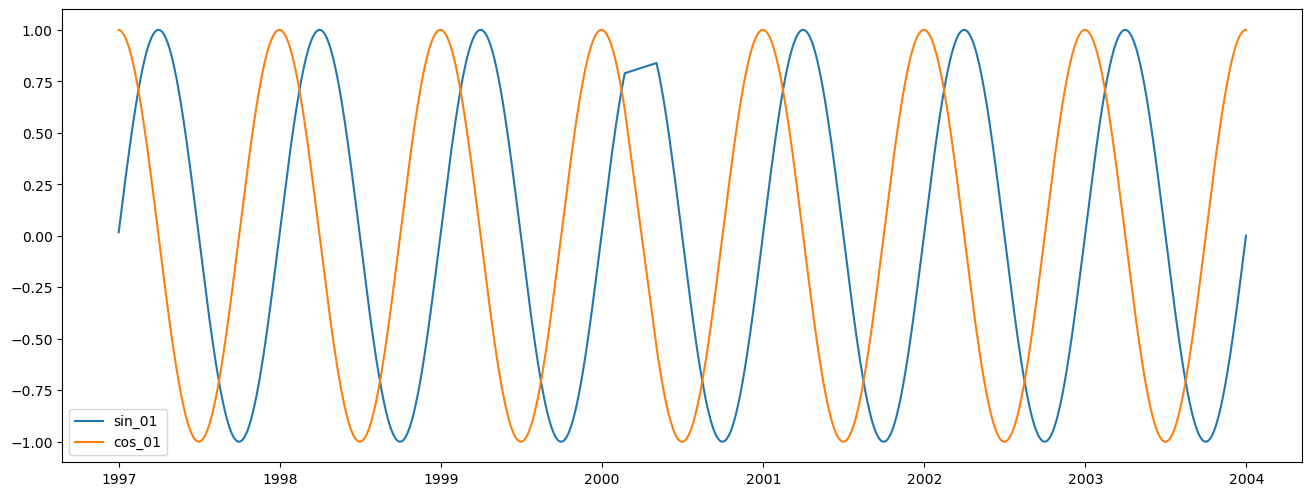

In [541]:
plot_series([dfD[dfD.date.dt.year<2004].sin_01,dfD[dfD.date.dt.year<2004].cos_01],None)

In [543]:
# Fit 10 models, up to maxFreq=10
sm_seasModel = [None]
results = [None]
for freq in range(1,1+maxFreq): 
    components_TL = [(('sin_%02d'%f),('cos_%02d'%f)) for f in range(1,1+freq)]
    components = [component for pair in components_TL for component in pair]
    sm_seasModel.append(OLS(dfD.temperature,sm.add_constant(dfD[components]),missing='drop'))
    results.append(sm_seasModel[-1].fit())


In [552]:
print(results[1].params)
print()
print(results[1].tvalues)
print()
print(results[1].t_test([1,0,0]))
print()
print(results[1].t_test([0,1,0]))
print()
print(results[1].t_test([0,0,1]))

const     14.466217
sin_01    -3.336496
cos_01    -9.210996
dtype: float64

const     359.668806
sin_01    -58.519676
cos_01   -162.329951
dtype: float64

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            14.4662      0.040    359.669      0.000      14.387      14.545

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -3.3365      0.057    -58.520      0.000      -3.448      -3.225

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

In [555]:
pred_01 = results[1].params.const + results[1].params.sin_01*dfD.sin_01 + results[1].params.cos_01*dfD.cos_01

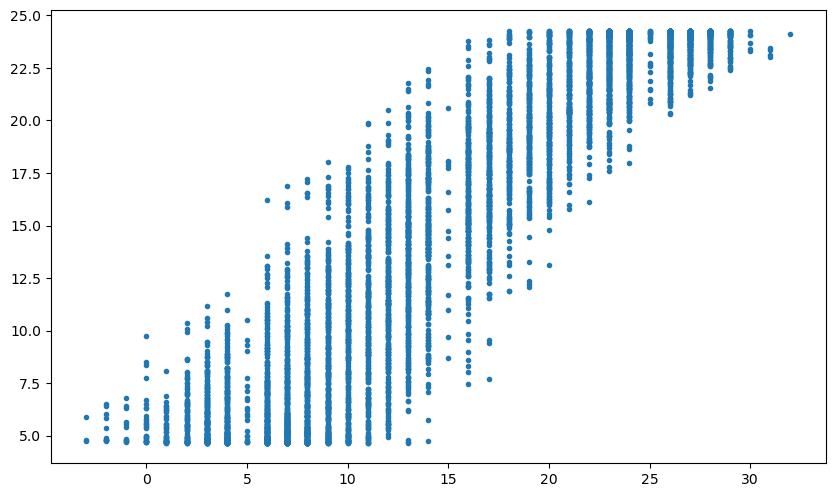

In [556]:
plt.plot(dfD.temperature,pred_01,'.')

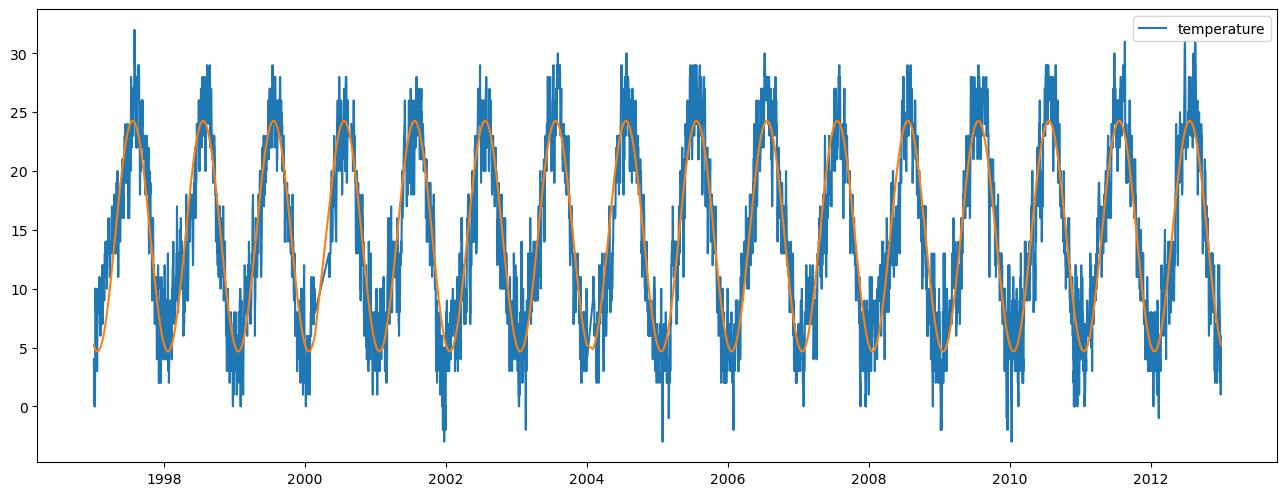

In [559]:
plot_series([dfD.temperature,pred_01],None)

In [ ]:
plo

date
1997-01-01    4.0
1997-01-02    3.0
1997-01-03    3.0
1997-01-04    3.0
1997-01-05    0.0
             ... 
2012-12-27    2.0
2012-12-28    6.0
2012-12-29    1.0
2012-12-30    2.0
2012-12-31    2.0
Name: temperature, Length: 5717, dtype: float64

In [554]:
results[1].params.const

14.466217046594807

In [549]:
print(results[-1].params)
print()
print(results[-1].tvalues)
print()
freq=10
for compo in range(1+2*freq):
    vec = [0]*compo+[1]+[0]*(2*freq-compo)
    print(results[-1].t_test(vec))
print()
#print(results.t_test([0,1,0]))
print()
#print(results.t_test([0,0,1]))
print()
#print(results.HC0_se)

const     14.475508
sin_01    -3.337658
cos_01    -9.197048
sin_02     1.555397
cos_02     0.019488
sin_03    -0.074386
cos_03    -0.289586
sin_04    -0.081366
cos_04     0.113626
sin_05     0.269509
cos_05     0.216542
sin_06     0.011474
cos_06     0.068834
sin_07    -0.069881
cos_07    -0.096661
sin_08    -0.140491
cos_08    -0.065721
sin_09     0.009118
cos_09     0.092512
sin_10    -0.070584
cos_10     0.132753
dtype: float64

const     388.945981
sin_01    -63.262210
cos_01   -175.160426
sin_02     29.587541
cos_02      0.369822
sin_03     -1.414573
cos_03     -5.497234
sin_04     -1.543567
cos_04      2.162288
sin_05      5.114328
cos_05      4.119504
sin_06      0.218147
cos_06      1.307159
sin_07     -1.328838
cos_07     -1.835214
sin_08     -2.670716
cos_08     -1.248208
sin_09      0.173258
cos_09      1.757772
sin_10     -1.339758
cos_10      2.525578
dtype: float64

                             Test for Constraints                             
                 coef    std

In [469]:
trendModel_validDays = OLS(dfD.temperature,sm.add_constant(dfD.Year_f),missing='drop')
results = trendModel_validDays.fit()
print(results.params)

const    -37.938552
Year_f     0.026163
dtype: float64


In [193]:
results.params

const    -99.847605
Year_f     0.057065
dtype: float64

In [194]:
residuals = dfD.temperature - (results.params.const + results.params.Year_f*dfD.Year_f)

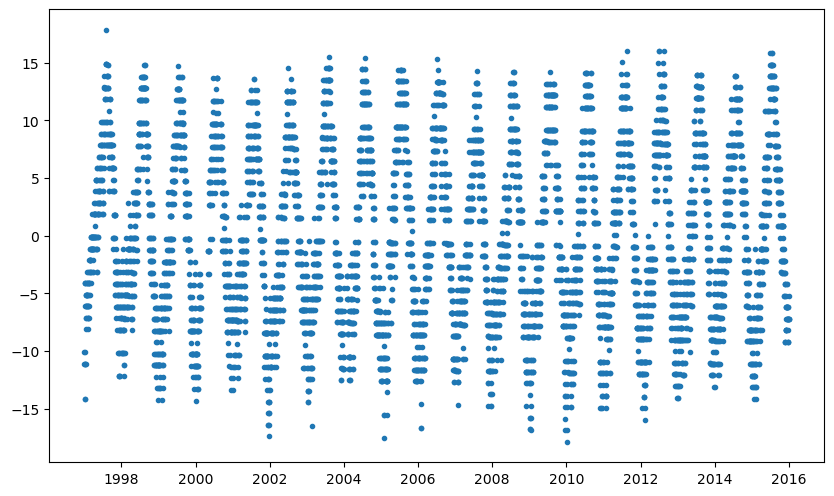

In [198]:
plt.plot(residuals,'.')

In [ ]:
Missing Data

https://cran.r-project.org/web/packages/imputeTS/imputeTS.pdf

In [117]:
plt.plot(df.date,df['Mean'])

88

In [127]:
df[['Mean TemperatureC']].isnull().update(df.date)

In [126]:
plot_series(df[['Mean TemperatureC']].isnull().update(df.date),'Mean TemperatureC')

AttributeError: 'NoneType' object has no attribute 'date'

<Figure size 1600x600 with 0 Axes>

In [13]:
19*365 - len(df) + 4

127

In [14]:
# 127 days missing   (4 leap years in the data set)
# inspection in Excel: 71 days missing in Spring 2000 (Feb 23 - May 3)
# Also parts of June 2000 and August 2000 are missing
# total of only 269 days in 2000

In [ ]:
# so 97 missing days in 2000
# should be 30 more somewhere else

In [20]:
pd.Series(df.index[df.CET.str.endswith('12-31')]).diff()

0       NaN
1     365.0
2     365.0
3     269.0
4     365.0
5     365.0
6     365.0
7     336.0
8     365.0
9     365.0
10    365.0
11    366.0
12    365.0
13    365.0
14    365.0
15    366.0
16    365.0
17    365.0
18    365.0
dtype: float64

In [26]:
# aha looks like the missing dates are all in 2000 and in 2004
# 30 missing dates in 2004
# It turns out they are all in January 2004: Jan 2-31 are all absent.

In [24]:
pd.Series(df.index[df.CET.str.startswith('2004-') & df.CET.str.endswith('-1')]).diff()

0      NaN
1      1.0
2     29.0
3     31.0
4     30.0
5     31.0
6     30.0
7     31.0
8     31.0
9     30.0
10    31.0
11    30.0
dtype: float64

In [224]:
pd.date_range(start=dfD.index[0], end=dfD.index[-1]) 

DatetimeIndex(['1997-01-01', '1997-01-02', '1997-01-03', '1997-01-04',
               '1997-01-05', '1997-01-06', '1997-01-07', '1997-01-08',
               '1997-01-09', '1997-01-10',
               ...
               '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',
               '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', length=6939, freq='D')

In [216]:
gho = dfD.temperature_max

In [219]:
gho.name

'temperature_max'

In [ ]:
# Thoughts

# Missing Data
    # Imputation? How?
    # Gaussian Processes???